In [11]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [26]:
# assigning X and y to data and target 
X, y = mnist['data'], mnist['target']
X.shape


(70000, 784)

In [24]:
y.shape
y[0]

'5'

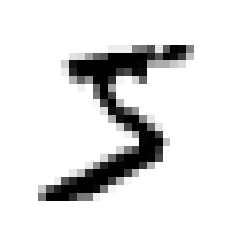

In [134]:
# looking at one digit in the dataset 
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0:1]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show() # matches the target output y[0]

In [45]:
import numpy as np
y = y.astype(np.uint8) # convert to a number
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: uint8

In [46]:
# train (first 60000) and test set (the last 10000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 

In [47]:
# first, binary classifier (5 and not 5) => creating the target vectors
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# Picking a classifier and evaluating model performance

picking a classfier => 
    Stochastic Gradient Descent - benefits: efficient on large data sets (deals with training instances independently)
        relies on randomness unless a random state is specified

In [62]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict(some_digit)

array([ True])

In [ ]:
# evaluating model performance
    # one way: cross validation as shown below
    
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfold = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

for train_index, test_index in skfold.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

In [64]:
from sklearn.model_selection import cross_val_score

# high accuracy is becuase most entries in this data set are not 5s (very skewed dataset)
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring ='accuracy') 

array([0.95035, 0.96035, 0.9604 ])

In [66]:
# when classifing all images in the not 5 column, there is a 90% accuracy!
    # doesn't actually measure the model's performance
    
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        # (len(X), 1) describes the shape of the numpy array (len x columns and 1 row)
        return np.zeros((len(X), 1), dtype=bool) 
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [67]:
    # second way: confusion matrix
# only want to use the test set at the very end so to use a confusion matrix, we need cross_val_predict
from sklearn.model_selection import cross_val_predict # how does this use clean data though if the model is fitted to the training data
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [68]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [69]:
# if the model was perfect, it would look like this: 
y_train_perfect = y_train_5
confusion_matrix(y_train_5, y_train_perfect)

array([[54579,     0],
       [    0,  5421]])

high recall but low precision = all of the stealers are caught but the 
cameras aren't always correct (some false positives)

low recall but high precision = all of the videos captured are correct, 
but there are also many correct videos that dont get captured

In [70]:
# if need a more concise metric => precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # measures the percentage that are correct (correct 84 % of the time)

0.8370879772350012

In [72]:
recall_score(y_train_5, y_train_pred) # measures the percentage of 5s detected

0.6511713705958311

f1 score is a harmonic mean of the recall and precision scores => gives more weight to low scores

   score will only be high if both recall and precision are high

In [74]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

# Precision/Recall Tradeoff

In [78]:
y_scores = sgd_clf.decision_function(some_digit)
y_scores

array([2164.22030239])

In [79]:
threshold = 0 # all the way to one side so same output as predict()
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [101]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # decreases recall because this output should be true

array([False, False, False, ..., False, False, False])

In [82]:
# deciding an appropriate decision_function threshold to use that will accurately draw the line between 5 and not 5
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [83]:
# compute the possible precision/recall curves for all of the possible thresholds printed above
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)

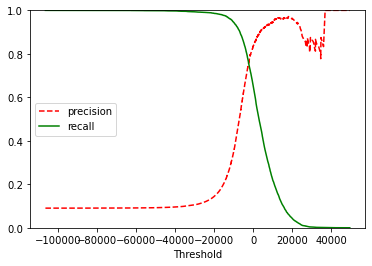

In [90]:
# plot on matplotlib
def plot_precision_recall_vs_threshold(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], 'r--', label="precision")
    plt.plot(threshold, recall[:-1],'g-', label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc='center left')
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precision, recall, threshold)
plt.show()

In [106]:
# if aiming for 90 % precision, the threshold will be around 10000
y_train_pred_90 = (y_scores > 10000)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [107]:
precision_score(y_train_5,y_train_pred_90)

0.946656050955414

In [108]:
recall_score(y_train_5, y_train_pred_90) # but very low recall score

0.21933222652647114

receiver operating characteristic (ROC) curve => tool for binary classification
plots true positive rate (recall or sensitivity) vs false positive rate 
FPR = ratio of negative instances that are incorrectly classified as positive (1 - true negative rate (specificity)
                                                                               
=> plots sensitivity (recall) vs 1 - specificity (true negative rate)

In [109]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

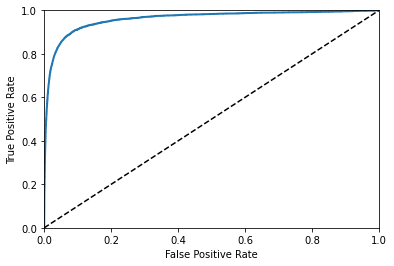

In [113]:
# plotting FPR against TPR in matplotlib
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()
# the higher the recall (TPR) the higher the false positives

to compare classifiers, a useful technique is to find the area under the curve (AUC). areas closer to 1 are ideal

the straight line classifier is randomly generated whose area is .5. This is not as ideal because the true positives rate increases with the false positives and our goal is to have a high TPR and low FPR

As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. 

In [114]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

# Compare to RandomForestClassifier

RandomForestClassifier doesn't have a decision function but has a predict_proba that find the probability of the instance being a 5 for example

- returns the probablity as a percent but can be used as a score as well

In [119]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba') 
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [124]:
y_scores_forest = y_probas_forest[:, 1] # probability of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

Random forest performs much better (this is evident because it is closer to the corner of the graph(the area under the curve is closer to 1))

- how does the the AUC determine the model performance though? What does it mean to have a good tradeoff? Why does that vary between models? is the goal just to get the most logical version? Will that always be where the AUC is 1?
- how to compute the precision and recall scores for the forest? do we need to specify a threshold? 

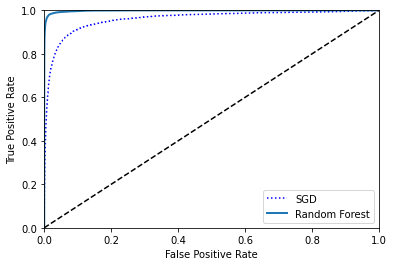

In [126]:
# plotting in matplotlib
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc='lower right')
plt.show()

In [127]:
roc_auc_score(y_train_5, y_scores_forest) # very good!!

0.9983436731328145

# Multiclass Classification

- can distinguish between more than two classes - Random Forest classifiers or naive Bayes classifiers can handle directly

One-vs-All strategy: you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score

One-vs-One strategy: train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on

when using a binary classification algorithm for multiclass task, it automatically uses OvA except when using Support Vector Machines Algorithm

for the code below, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

In [142]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(some_digit) # so OvA was wrong??

array([3], dtype=uint8)

In [133]:
some_digit_scores = sgd_clf.decision_function(some_digit) 
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [143]:
np.argmax(some_digit_scores)

3

In [144]:
sgd_clf.classes_ # list of target classes 

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [146]:
sgd_clf.classes_[3]

3

If you want to force the model to use the OvA or OvO strategy, you just declare it like so: 

In [148]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict(some_digit)

array([5], dtype=uint8)

training forest classifier => doesn't need either OvA or OvO strategy because RandomForest Classifiers are already mutliclass 
forest_clf.fit(X_train, y_train)

In [150]:
forest_clf.fit(X_train, y_train)
forest_clf.predict(some_digit)

array([5], dtype=uint8)

In [151]:
# probabilities each classifier assigned to each class
forest_clf.predict_proba(some_digit)

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

Evaluate the classifiers: for the SGDClassifier, use cross_val_score

In [155]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [160]:
# scaling the value increases the accuracy
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

# Error Analysis and Improving the Choosen Model

In [161]:
# confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

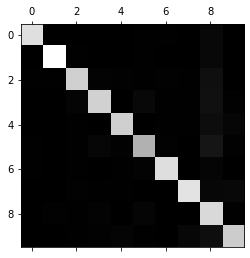

In [162]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The 5s look darker so to analyze that, we divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors

In [163]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

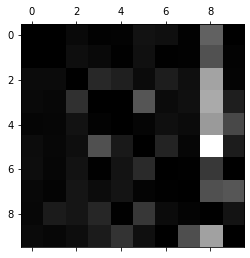

In [164]:
np.fill_diagonal(norm_conf_mx, 0) # fill the diagonal so the matrix only measures the errors
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Using this graph, there are many things that could be done to fix the errors (which seem to heavily misclassify the 8)

- gather more training data
- engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none)
- preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more


the model assigns a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. => easy to misclassify 3 and 5, especially using a simple linear classifier like SGDClassifier

# Multilabel Classification

be able to recognize several different labels within one object

In [174]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [175]:
knn_clf.predict(some_digit) # smaller than 5, but odd

array([[False,  True]])

Evaluating a multilable classifier

- measure the F1 score for each label and compute average

if the labels are uneven in the dataset or we want them to be unequal, we can set the average='weighted' which would assign weights according to the support in the data

In [176]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3) # returns the predicted score
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

# Multioutput Classification

ex. removing the noise from images => output is the pixel intensities which have 255 outputs

adding noise with random integers around the 5

the target features will be the original numbers in the x values

- wouldn't that change the intensity that cover the 5 though? is that the point?

In [192]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
X_train_mod
X_test_mod

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
60000,11.0,3.0,49.0,19.0,13.0,98.0,75.0,71.0,83.0,71.0,...,17.0,29.0,54.0,23.0,70.0,36.0,40.0,45.0,2.0,81.0
60001,99.0,98.0,50.0,36.0,88.0,70.0,86.0,10.0,12.0,48.0,...,93.0,22.0,87.0,52.0,60.0,65.0,98.0,52.0,71.0,78.0
60002,98.0,7.0,31.0,90.0,52.0,64.0,79.0,1.0,21.0,38.0,...,8.0,95.0,42.0,19.0,49.0,59.0,62.0,38.0,89.0,38.0
60003,8.0,11.0,46.0,39.0,46.0,53.0,77.0,87.0,2.0,3.0,...,52.0,34.0,88.0,71.0,4.0,1.0,82.0,15.0,11.0,19.0
60004,44.0,14.0,52.0,25.0,48.0,14.0,49.0,91.0,68.0,33.0,...,9.0,81.0,34.0,47.0,52.0,28.0,98.0,43.0,55.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,28.0,33.0,44.0,37.0,69.0,8.0,16.0,82.0,5.0,16.0,...,88.0,27.0,72.0,41.0,91.0,35.0,15.0,64.0,60.0,15.0
69996,73.0,49.0,32.0,40.0,52.0,72.0,72.0,25.0,2.0,14.0,...,52.0,35.0,65.0,45.0,35.0,44.0,17.0,95.0,47.0,88.0
69997,76.0,55.0,82.0,74.0,81.0,79.0,28.0,91.0,14.0,15.0,...,41.0,71.0,12.0,24.0,5.0,0.0,15.0,49.0,58.0,15.0
69998,35.0,69.0,25.0,46.0,18.0,84.0,98.0,28.0,6.0,67.0,...,56.0,5.0,65.0,50.0,85.0,99.0,73.0,13.0,27.0,89.0


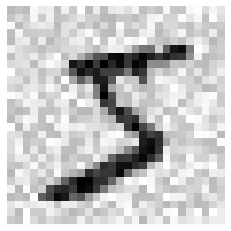

In [193]:
some_digit = X_train_mod.iloc[0:1]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [194]:
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

train the classifier and try to get the mod 5 to match the target

In [200]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(X_test_mod.iloc[0:1])

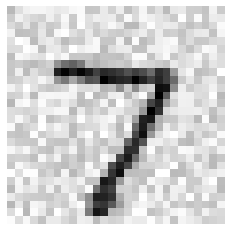

In [203]:
# NOISY
some_digit = X_test_mod.iloc[0:1]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

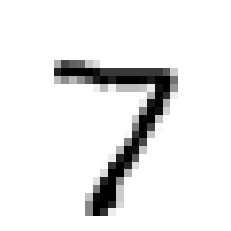

In [204]:
# TARGET
some_digit = X_test.iloc[0:1]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

So much better! => the model works fairly well that means because it is quite similar to the target above

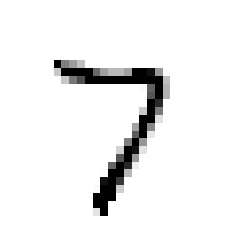

In [202]:
# PREDICTED
some_digit_image = clean_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()